In [28]:
import cv2
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import skimage
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
import shutil
from scipy import stats
from time import time
from glob import glob
sys.path.append(os.environ['REPO_DIR'])
from lib.utils import configuration, run
from matplotlib.path import Path
from shapely.geometry import Polygon
import mxnet as mx

In [3]:
def setup_download_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(s3_fp, local_fp))
    else:
        run('aws s3 cp {0} {1}'.format(s3_fp, local_fp))

def setup_upload_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(local_fp, s3_fp))
    else:
        run('aws s3 cp {0} {1}'.format(local_fp, s3_fp))

In [7]:
MXNET_ROOTDIR = 'mxnet_models'
model_dir_name = 'inception-bn-blue-softmax'
model_name = 'inception-bn-blue-softmax'
setup_download_from_s3(os.path.join(MXNET_ROOTDIR, model_dir_name, 'mean_224.npy'), recursive=False)
mean_img = np.load(os.path.join(os.environ['ROOT_DIR'], MXNET_ROOTDIR, model_dir_name, 'mean_224.npy'))

ALREADY DOWNLOADED FILE


In [14]:
stack = 'MD594'
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}


fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
setup_download_from_s3(fname, recursive=False)
annotation = np.load(os.environ['ROOT_DIR']+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')
contours_struc = contours.groupby('name')
valid_sections = np.sort(contours['section'].unique())

paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE


In [41]:
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

In [20]:
%%time
model_prefix = os.path.join(MXNET_ROOTDIR, model_dir_name, model_name)
for structure in all_structures:
    setup_download_from_s3(model_prefix+'_'+structure+'-symbol.json', recursive=False)
    setup_download_from_s3(model_prefix+'_'+structure+'-0045.params', recursive=False)

run cmd= aws s3 cp s3://mousebrainatlas-data/mxnet_models/inception-bn-blue-softmax/inception-bn-blue-softmax_5N-symbol.json /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/mxnet_models/inception-bn-blue-softmax/inception-bn-blue-softmax_5N-symbol.json
run cmd= aws s3 cp s3://mousebrainatlas-data/mxnet_models/inception-bn-blue-softmax/inception-bn-blue-softmax_5N-0045.params /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/mxnet_models/inception-bn-blue-softmax/inception-bn-blue-softmax_5N-0045.params
run cmd= aws s3 cp s3://mousebrainatlas-data/mxnet_models/inception-bn-blue-softmax/inception-bn-blue-softmax_6N-symbol.json /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/mxnet_models/inception-bn-blue-softmax/inception-bn-blue-softmax_6N-symbol.json
run cmd= aws s3 cp s3://mousebrainatlas-data/mxnet_models/inception-bn-blue-softmax/inception-bn-blue-softmax_6N-0045.params /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/mxnet_models/inception-bn-blue-softmax/inception-bn-blue-softmax_6N-0045

run cmd= aws s3 cp s3://mousebrainatlas-data/mxnet_models/inception-bn-blue-softmax/inception-bn-blue-softmax_Sp5C-0045.params /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/mxnet_models/inception-bn-blue-softmax/inception-bn-blue-softmax_Sp5C-0045.params
run cmd= aws s3 cp s3://mousebrainatlas-data/mxnet_models/inception-bn-blue-softmax/inception-bn-blue-softmax_PBG-symbol.json /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/mxnet_models/inception-bn-blue-softmax/inception-bn-blue-softmax_PBG-symbol.json
run cmd= aws s3 cp s3://mousebrainatlas-data/mxnet_models/inception-bn-blue-softmax/inception-bn-blue-softmax_PBG-0045.params /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/mxnet_models/inception-bn-blue-softmax/inception-bn-blue-softmax_PBG-0045.params
run cmd= aws s3 cp s3://mousebrainatlas-data/mxnet_models/inception-bn-blue-softmax/inception-bn-blue-softmax_10N-symbol.json /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/mxnet_models/inception-bn-blue-softmax/inception-bn-blue-softma

In [179]:
os.path.exists(os.environ['ROOT_DIR'] + model_prefix + '_' + structure + '-symbol.json')

True

In [180]:
while os.path.exists(os.environ['ROOT_DIR'] + model_prefix + '_' + structure + '-symbol.json')==0:
    setup_download_from_s3(model_prefix + '_' + structure + '-symbol.json', recursive=False)
    setup_download_from_s3(model_prefix + '_' + structure + '-0045.params', recursive=False)

In [92]:
%%time
structure = '10N'
patch_dir = os.path.join('CSHL_patch_samples',stack)
setup_download_from_s3(os.path.join(patch_dir,structure))
setup_download_from_s3(os.path.join(patch_dir,structure+'_surround_500um_noclass'))
patches = [dir for dir in glob(os.environ['ROOT_DIR']+patch_dir+'/'+structure+'/*')]
n_pos = len(patches)
patches.extend([dir for dir in glob(os.environ['ROOT_DIR']+patch_dir+'/'+structure+'_surround_500um_noclass/*')])
model, arg_params, aux_params = mx.model.load_checkpoint(os.path.join(os.environ['ROOT_DIR'],\
                                                                      model_prefix+'_'+structure),45)

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
CPU times: user 25 ms, sys: 48.2 ms, total: 73.3 ms
Wall time: 98.6 ms


In [94]:
%%time
batch_size = len(patches)
mod = mx.mod.Module(symbol=model, label_names=None, context=mx.cpu())
mod.bind(for_training = False,
         data_shapes=[('data', (batch_size,1,224,224))])
mod.set_params(arg_params, aux_params, allow_missing=True)
img = np.array([cv2.imread(dir, 0) for dir in patches])
test = (img-mean_img)[:,None,:,:]
mod.forward(Batch([mx.nd.array(test)]))

CPU times: user 835 ms, sys: 571 ms, total: 1.41 s
Wall time: 2.31 s


In [100]:
prob = mod.get_outputs()[0].asnumpy()
pred = np.argsort(prob, axis=1)
top1 = pred[:,-1]
labels = np.zeros(batch_size)
labels[:n_pos] = 1
sum(top1==labels)/batch_size

0.9068219633943427

In [123]:
mod.get_outputs()[0].asnumpy()[:,1].

0.4017839

In [106]:
prob[:n_pos,:].sum(axis=0)/n_pos

array([0.16163097, 0.8383692 ], dtype=float32)

In [103]:
prob.sum(axis=0)

array([359.52798, 241.47205], dtype=float32)

In [114]:
xs, ys = np.meshgrid(np.arange(0, 100, 10), np.arange(0, 100, 10), indexing='xy')
windows = np.c_[xs.flat, ys.flat]+5

In [121]:
windows.shape

(100, 2)

In [128]:
%%time
! python ../scripts/Shape_shift_cnn.py 'MD594' 110

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
[06:09:05] src/nnvm/legacy_json_util.cc:209: Loading symbol saved by previous version v0.9.5. Attempting to upgrade...
[06:09:05] src/nnvm/legacy_json_util.cc:217: Symbol successfully upgraded!
^C
CPU times: user 21.1 s, sys: 7.03 s, total: 28.1 s
Wall time: 13min 49s


In [129]:
import pickle
scores = pickle.load(open('/Users/kuiqian/Downloads/94.pkl','rb'))

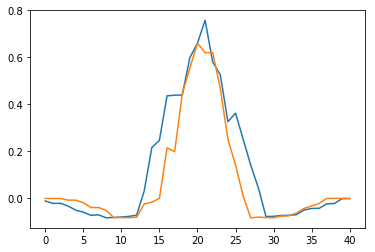

In [137]:
plt.plot(np.array(scores['VCA']['94_positive']['x'])-np.array(scores['VCA']['94_negative']['x']))
plt.plot(np.array(scores['VCA']['94_positive']['y'])-np.array(scores['VCA']['94_negative']['y']))

In [138]:
savepath = 'CSHL_shift_cnn/MD594/'

In [140]:
setup_download_from_s3(savepath)

run cmd= aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_shift_cnn/MD594/ /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_shift_cnn/MD594/


In [142]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'Polygon', 'f', 'mod', 'time', 'stack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


CPU times: user 1.67 s, sys: 239 ms, total: 1.91 s
Wall time: 2.05 s


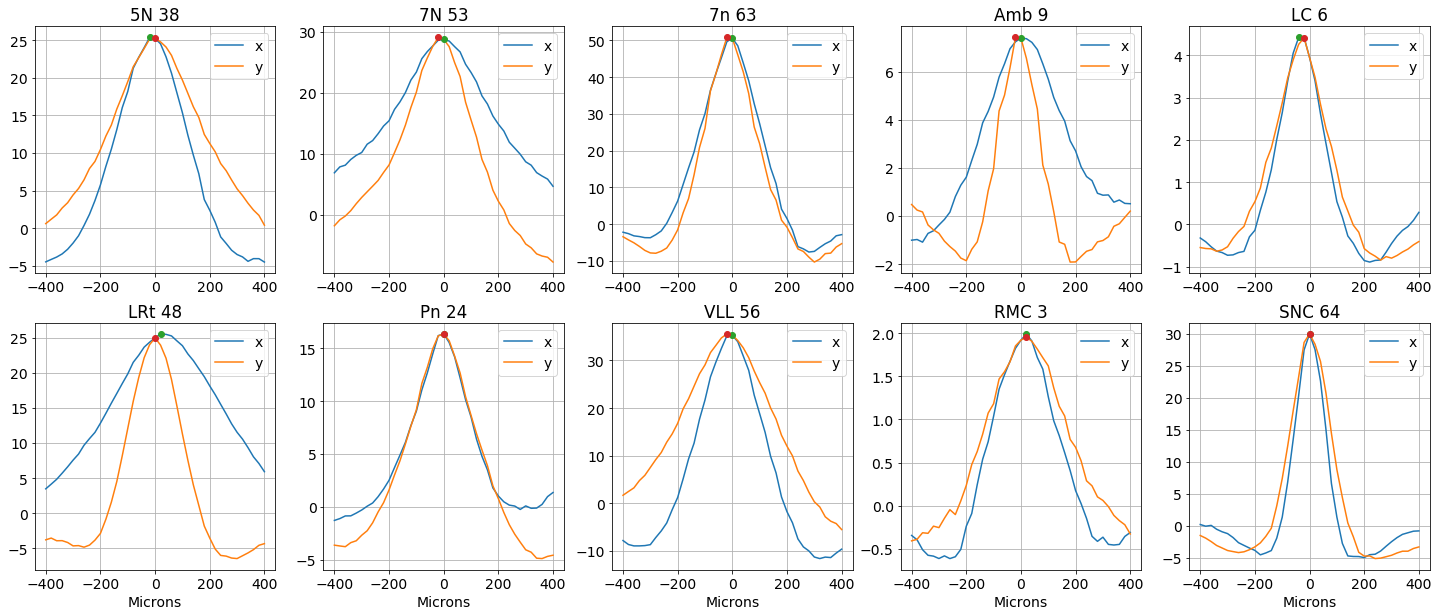

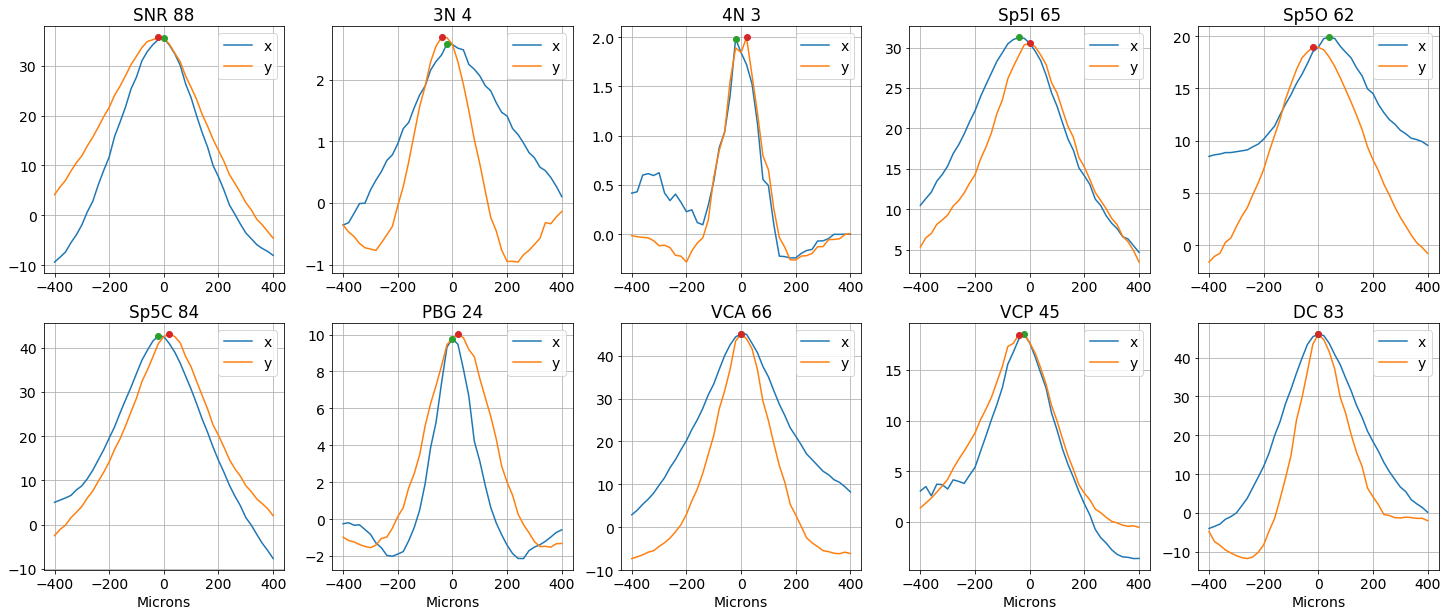

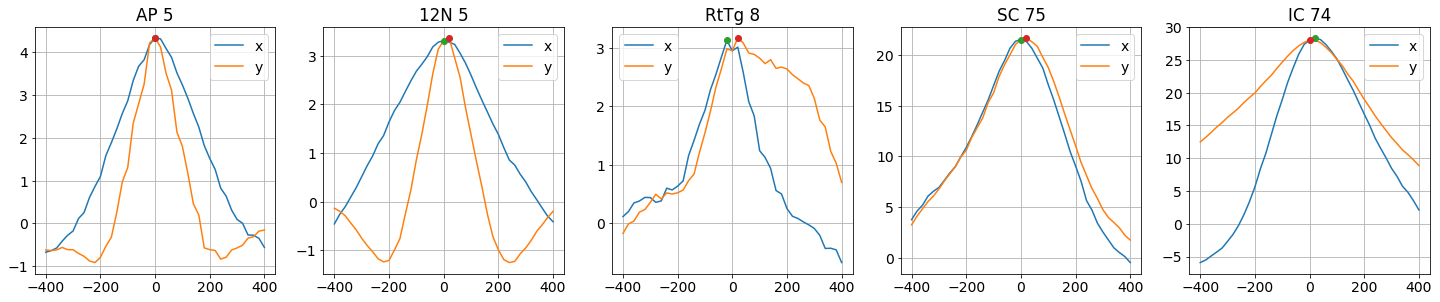

In [176]:
%%time
i = 0
j = 0
figure(figsize=(25,10))
rc('font', size=14)
for structure in all_structures:
    seq = sort(contours_struc.get_group(structure)['section'].unique())
    x_shift = []
    y_shift = []
#     z_shift = []
    for state in ['positive','negative']:
        for section in seq:
            filename = savepath + str(section)+ '.pkl'
            try:
                scores = pickle.load(open(os.environ['ROOT_DIR']+filename,'rb'))
            except:
                continue
            x_score= scores[structure][str(section)+'_'+state]['x']
            x_shift.append(x_score)
            y_score= scores[structure][str(section)+'_'+state]['y']
            y_shift.append(y_score)
#             z_score= scores[structure][str(section)+'_'+state]['z']
#             z_shift.append(z_score)
    x_shift=np.array(x_shift)
    y_shift=np.array(y_shift)
#     z_shift=np.array(z_shift)
#     num = len(seq)
    num = len(x_shift)//2
    if num==0:
        continue
    x_sum = x_shift[:num,:].sum(axis=0) - x_shift[num:,:].sum(axis=0)
    x_final = x_sum#np.array([x[0] for x in x_sum])
    y_sum = y_shift[:num,:].sum(axis=0) - y_shift[num:,:].sum(axis=0)
    y_final = y_sum#np.array([x[0] for x in y_sum])
#     z_sum = z_shift[:num,:].sum(axis=0) - z_shift[num:,:].sum(axis=0)
#     z_final = np.array([x[0] for x in z_sum])
    i +=1
    if i==11:
        i=1
        j += 1
        filename = 'Shift'+str(j)+'.jpg'
#         savefig(filename, bbox_inches='tight')
        figure(figsize=(25,10))
    subplot(2,5,i)
    rc('font', size=14)

    coords = np.arange(-20,21)*20
    
    arrowprops=dict(arrowstyle="->") #,connectionstyle="angle,angleA=0,angleB=60"
    kw = dict(arrowprops=arrowprops)
    
    plot(coords, x_final, label='x')
    x1, y1 = coords[np.argmax(x_final)], x_final.max()
#     if x1==0:
#         annotate("{:d}, {:.1f}".format(x1, y1), (x1, y1))
#     else:
#         annotate("{:d}, {:.1f}".format(x1, y1), (x1, y1), (x1+20, y1-20), **kw)
    half_way1 = x_final.max()/2
#     if np.min(np.absolute(x_final[:np.argmax(x_final)]-half_way1))<5 \
#     and np.min(np.absolute(x_final[np.argmax(x_final):]-half_way1))<5:
#             x_half = 1
#             left = np.argmin(np.absolute(x_final[:np.argmax(x_final)]-half_way1))
#             right = np.argmin(np.absolute(x_final[np.argmax(x_final):]-half_way1))
#             print(x_final[left]-half_way1, x_final[right]-half_way1)
#     else:
#         x_half = 0
    
    plot(coords, y_final, label='y')
    x2, y2 = coords[np.argmax(y_final)], y_final.max()
#     if x2==x1:
#         annotate("{:d}, {:.1f}".format(x2, y2), (x2, y2))
#     else:
#         annotate("{:d}, {:.1f}".format(x2, y2), (x2, y2), (x2+20, y2+5), **kw)
    half_way2 = y_final.max()/2
    
#     plot(coords, z_final, label='z')
#     x3, y3 = coords[np.argmax(z_final)], z_final.max()
#     if x3==x1:
#         annotate("{:d}, {:.1f}".format(x3, y3), (x3, y3))
#     else:
#         annotate("{:d}, {:.1f}".format(x3, y3), (x3, y3), (x3-20, y3-5), **kw)
#     half_way3 = z_final.max()/2
    
    plot(x1, y1, 'o')
    plot(x2, y2, 'o')
#     plot(x3, y3, 'o')
#     plot(coords, [half_way1]*41, '--')
#     plot(coords, [half_way2]*41, '--')
#     plot(coords, [half_way3]*41, '--')

#     if x_half==1:
#         plot([coords[left], coords[right]], [x_final[left], x_final[right]], 'o')
    if i>5:
        xlabel('Microns')
    legend()
    grid(True)
    title(structure +' '+ str(num))
# savefig('Shift2.jpg')